In [80]:
import psycopg2
import requests
import polyline
import random

import matplotlib.pyplot as plt
import contextily as ctx

from geopy.distance import distance
from geopy.point import Point
from geopy.distance import geodesic

In [81]:
conn = psycopg2.connect(
    host="localhost",
    database="gpx",
    user="root",
    password="root"
)

In [82]:
def get_points(lat, lon, distance_meters):
    try:
        query = f"""
    WITH points AS (
        SELECT ST_MakePoint(longitude, latitude) AS point    

        FROM (
            SELECT id, name, latitude, longitude FROM points
            UNION ALL
            SELECT id, name, latitude, longitude FROM segments
            UNION ALL
            SELECT id, name, latitude, longitude FROM random
        ) AS combined
        WHERE ST_DWithin(
            ST_MakePoint(longitude, latitude)::geography,
            ST_MakePoint({lon}, {lat})::geography,
            {distance_meters}
        )
    ),
    convex_hull AS (
        SELECT ST_ConvexHull(ST_Collect(point)) AS polygon
        FROM points
    ),
    polygon AS (
        SELECT ST_AsText(ST_PointN(ST_ExteriorRing(polygon), generate_series(1, ST_NumPoints(ST_ExteriorRing(polygon))))) AS point_sequence
        FROM convex_hull
    )
    SELECT 
        ST_Y(point_sequence) AS latitude,
        ST_X(point_sequence) AS longitude
    FROM polygon;
        """

        with conn.cursor() as cur:
            cur.execute(query)
            rows = cur.fetchall()    

        return rows
    except Exception as e:
        print(f'Error: {e}')
        conn.rollback()

In [83]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

In [84]:
def get_route(points):
    points = ';'.join(map(osrm_format, points))
    params = {
        'geometries': 'polyline6',
    }
    
    response = requests.get(f"http://127.0.0.1:6000/route/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        return None
    
    geometry = routes['routes'][0]['geometry']
    return polyline.decode(geometry, 6)

In [85]:
def plot_gpx(route, ax):
    latitudes = [point[0] for point in route]
    longitudes = [point[1] for point in route]
    ax.plot(longitudes, latitudes, color='red', label='Route')
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

In [111]:
def get_center_point(lat, lng, distance_meters):    
    bearing = random.uniform(0, 360)
    original_point = Point(lat, lng)
    
    point = distance(meters=distance_meters).destination(original_point, bearing)
    return (point.latitude, point.longitude)
  
def get_points_on_circle(lat, lng, distance_meters):
    points = []

    (lat, lon) = get_center_point(lat, lng, distance_meters)
    center_point = Point(lat, lon)
    
    num_points = random.randint(10, 20)
    angle_interval = 360 / num_points
    
    for i in range(num_points):
        angle = angle_interval * i
        point = distance(meters=distance_meters).destination(point=center_point, bearing=angle)
        points.append((point.latitude, point.longitude))

    return points

def create_random_points(start_lat, start_lng, distance_meters):
    points = get_points_on_circle(start_lat, start_lng, distance_meters)
    random2postgis(points)

def random2postgis(points):
    try:
        cursor = conn.cursor()

        create_table = f"""
DROP TABLE IF EXISTS random;

CREATE TABLE IF NOT EXISTS random (
    id SERIAL PRIMARY KEY,
    name VARCHAR(255),
    latitude DECIMAL,
    longitude DECIMAL
);
"""
        cursor.execute(create_table)
        conn.commit()

        for point in points:
            (lat, lon) = point

            insert_query = f"""
INSERT INTO random 
(name, latitude, longitude) 
VALUES ('random', {lat}, {lon});
"""
            cursor.execute(
                insert_query
            )
            conn.commit()
                
    except Exception as e:
        print(f'Error: {e}')
        conn.rollback()

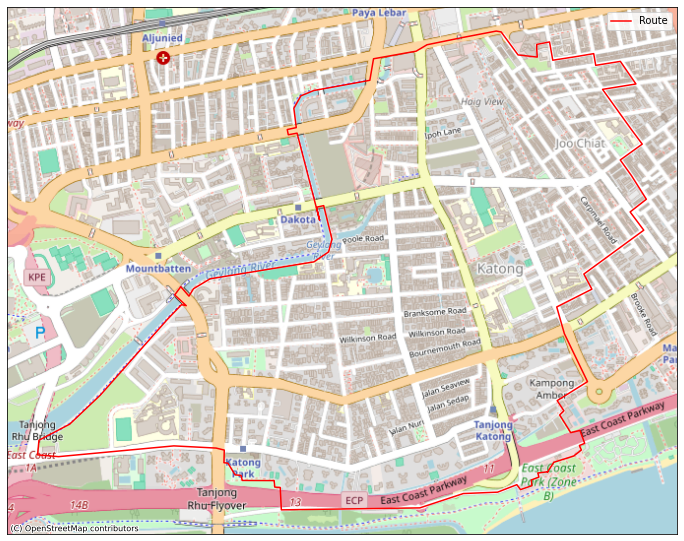

In [112]:
start = (1.3097970339490435, 103.89455470068188)
distance_meters = 2000
random_distance_meters = 500

start_lat, start_lng = start

create_random_points(start_lat, start_lng, random_distance_meters)
points = get_points(start_lat, start_lng, distance_meters)

osrm_route = get_route(points) 

fig, ax = plt.subplots(1, 1, figsize=(12, 30))
plot_gpx(osrm_route, ax)
plt.show()